In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from spender.data import desi
from spender import load_model

from util import trapz_rebin

from hubersed.paths import PATHS
from hubersed.style import *

RESULTS_PATH = PATHS['RESULTS']
DATA_PATH = PATHS['DATA']

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
inst = desi.DESI()
z_max = 0

In [4]:
lmbda_min = inst.wave_obs[0] / (1.0 + z_max)
lmbda_max = inst.wave_obs[-1]
bins = int((lmbda_max-lmbda_min).item()/0.8)
wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)

In [8]:
n_latent = 10
filename = str(DATA_PATH / 'desi_noise_spender_10latent.pt')

model = load_model(filename=filename, instrument=inst, map_location=device, weights_only=False)
model.eval()

SpectrumAutoencoder(
  (encoder): SpectrumEncoder(
    (instrument): DESI()
    (conv1): Sequential(
      (0): Conv1d(1, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=128)
      (3): Dropout(p=0, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=256)
      (3): Dropout(p=0, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(21,), stride=(1,), padding=(10,))
      (1): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=512)
      (3): Dropout(p=0, inplace=False)
    )
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=2, dilation=1, ceil_mode=False)
    

In [10]:
loader = inst.get_data_loader(
    '/Users/ng27753/Astronomy_Research/spender/DATA/',
    tag="chunk1024",
    which="valid",
    batch_size=64,
    shuffle=False,
    shuffle_instance=False,
)

In [11]:
latents = []
decodes = []
snrs = []
weights = []
w_s = []
spectra = []

In [12]:
with torch.no_grad():
    for i, batch in enumerate(loader):
        spec, w, z = batch
        snr = spec * torch.sqrt(w)
        snr = snr.to(device)
        snrs.append(snr.cpu().numpy())

        # mask out zero-weighted pixels
        weight = torch.ones_like(w)
        weight[w == 0] = 0
        weights.append(weight.cpu().numpy())

        s = model.encode(snr)
        latents.append(s.cpu().numpy())

        recon = model.decode(s)
        decodes.append(recon.cpu().numpy())

        w_s.append(w.cpu().numpy())
        spectra.append(spec.cpu().numpy())
        break # only do one batch

In [13]:
# get random index
idx = np.random.randint(0, snrs[0].shape[0], size=6)
print(idx)

[41 12 10 13 20 31]


/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_15673/4052197358.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  wave_rebin = np.arange(model.wave_obs[0], model.wave_obs[-1], 10)[1:-1]
/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_15673/4052197358.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  snr_rebin = trapz_rebin(np.array(model.wave_obs), np.array(snrs[0][index]), xnew=wave_rebin)


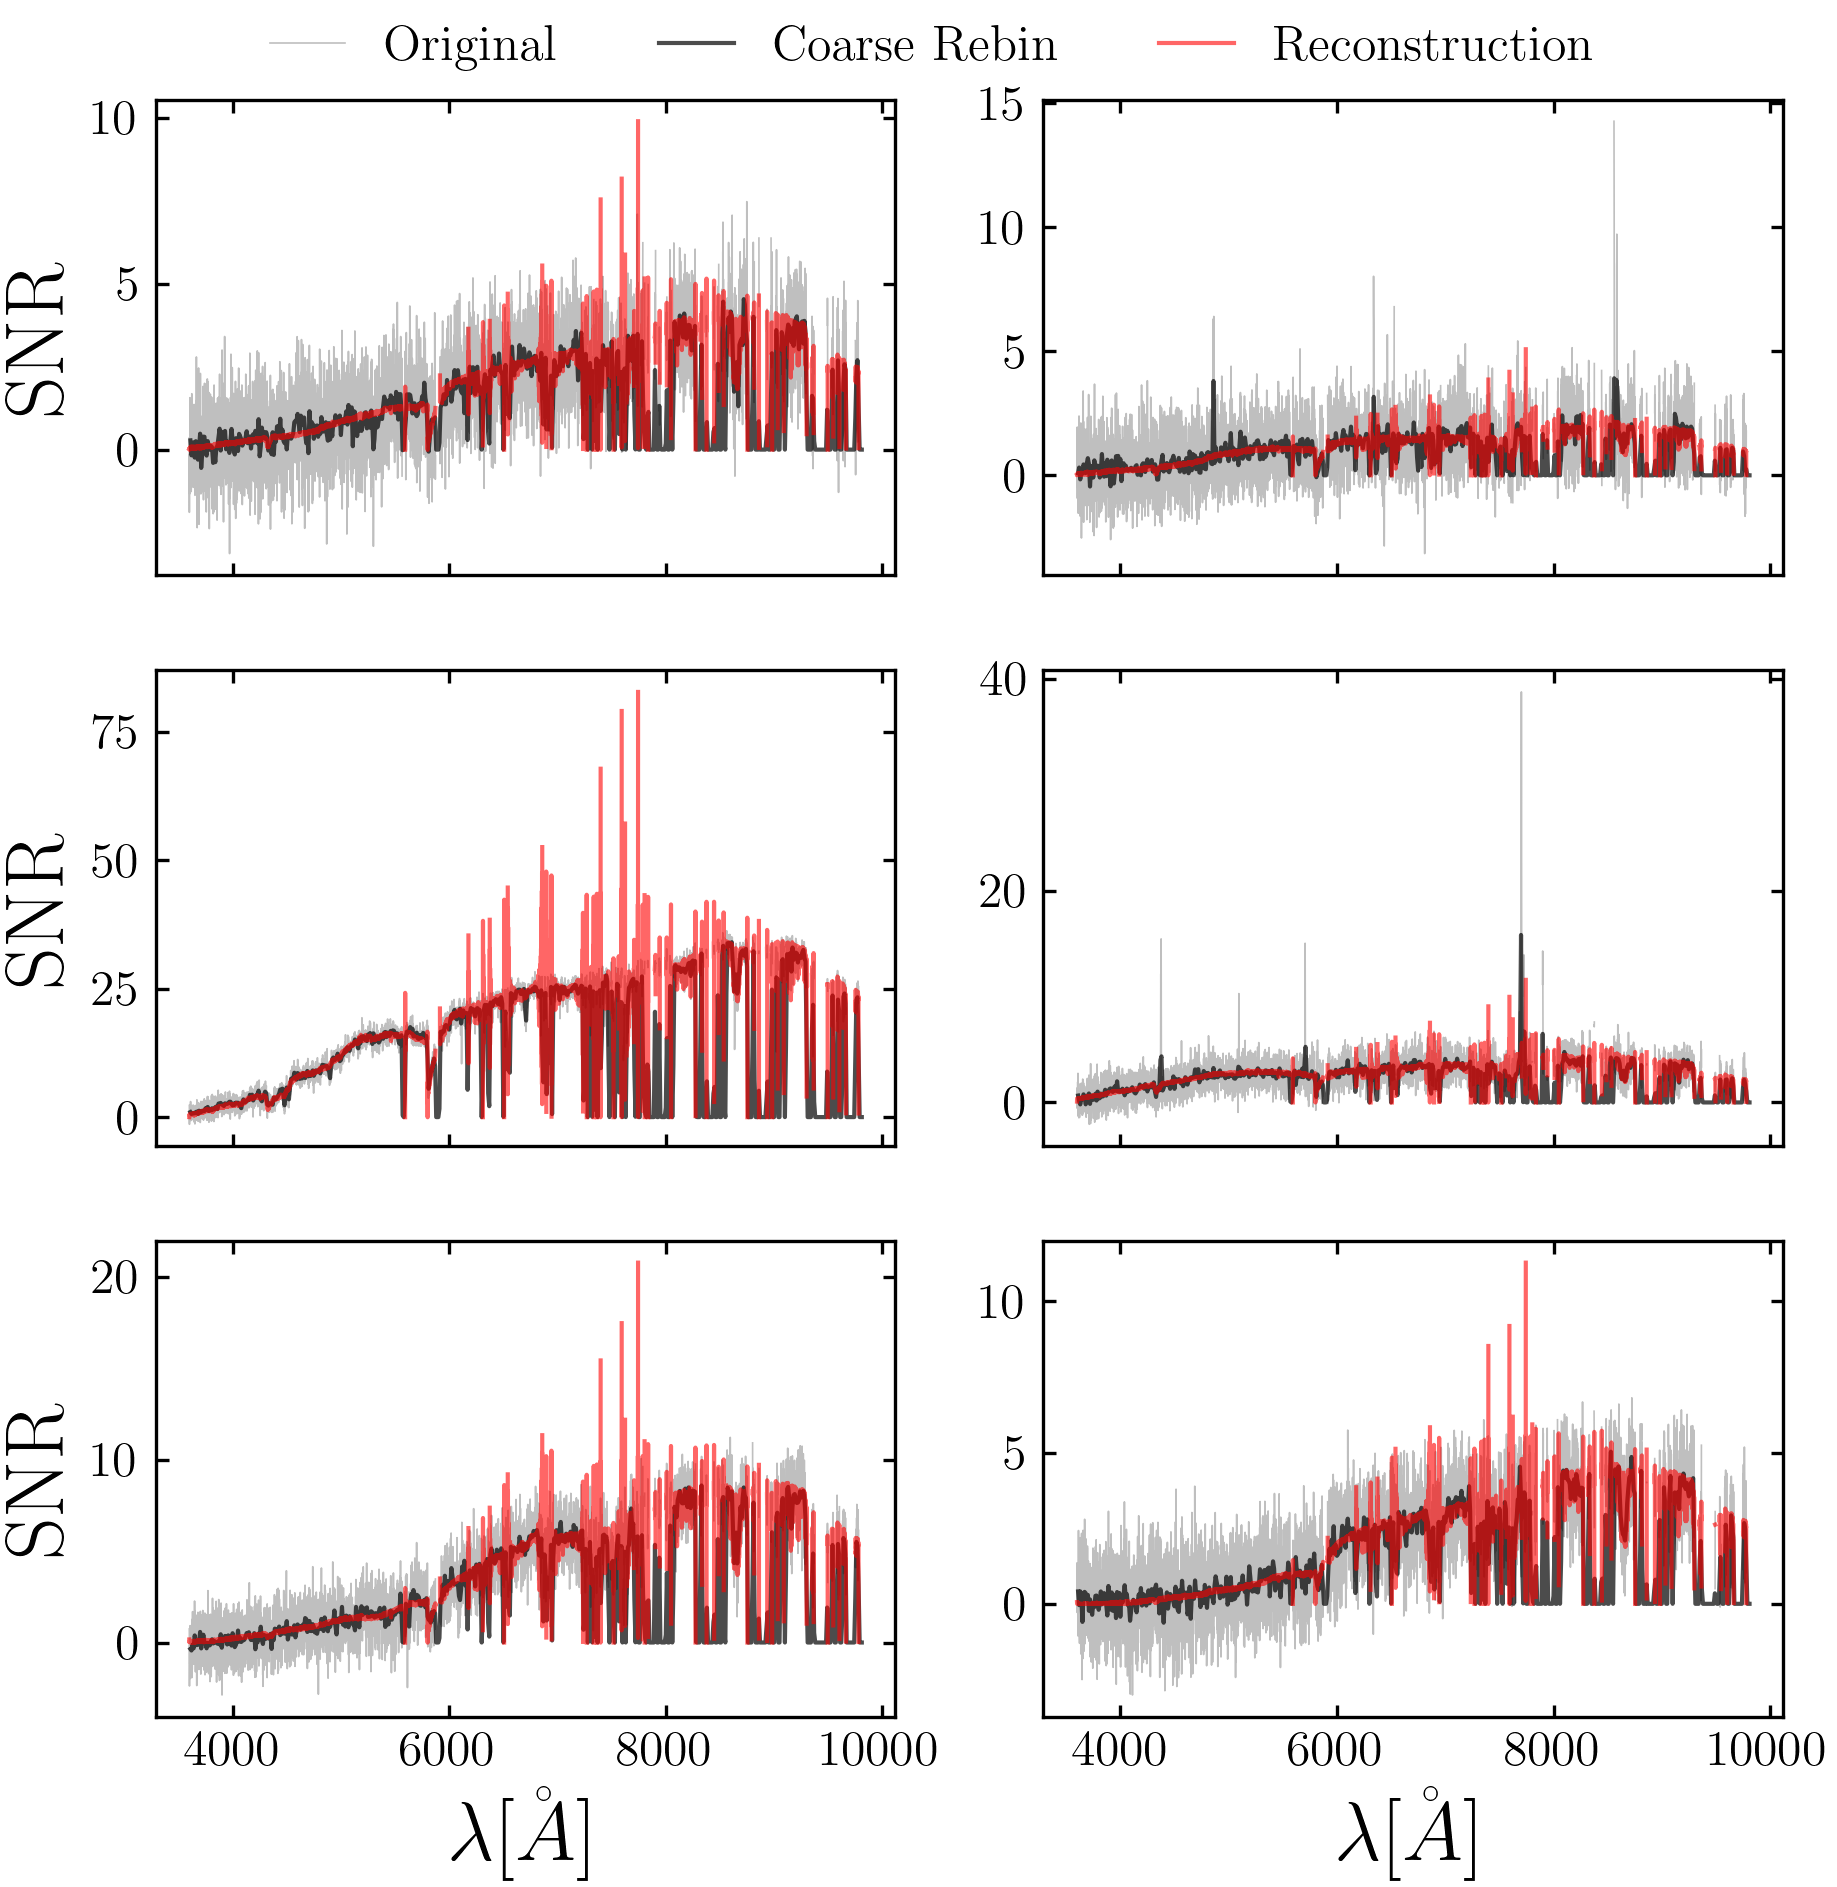

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(7, 3.5*2), sharex=True)
ax = ax.flatten()

wave_rebin = np.arange(model.wave_obs[0], model.wave_obs[-1], 10)[1:-1]

for i in range(6):
    index = idx[i]
    
    # mask out w_s[0][i] == 0 to nan
    mask = w_s[0][index][:-1] == 0

    original = snrs[0][index][:-1].copy()
    original[mask] = np.nan

    reconstructed = decodes[0][index].copy()
    reconstructed[mask] = np.nan

    snr_rebin = trapz_rebin(np.array(model.wave_obs), np.array(snrs[0][index]), xnew=wave_rebin)

    ax[i].plot(model.wave_obs[:-1], original, label='Original', color='gray', alpha=0.5, lw=0.4)

    ax[i].plot(wave_rebin, snr_rebin, label='Coarse Rebin', color='black', alpha=0.7, linestyle='-', lw=1)


    ax[i].plot(model.wave_obs[:-1], reconstructed, label='Reconstruction', color='red', alpha=0.6, lw=1)

    # ax[i].axhline(y=0, color='black', linestyle='--', alpha=0.7)

    # text bottom right with index
    # ax[i].text(0.95, 0.03, f'Index: {index}', transform=ax[i].transAxes,
    #            horizontalalignment='right', verticalalignment='bottom', fontsize=8)
# ax[0].legend()

# legend outside plot on top center
ax[0].legend(bbox_to_anchor=(1.05, 1.25), loc='upper center', ncol=3, fontsize=12, frameon=False)

ax[-1].set_xlabel(r'$\lambda [\AA]$', fontsize=20)
ax[-2].set_xlabel(r'$\lambda [\AA]$', fontsize=20)

ax[0].set_ylabel('SNR', fontsize=20)
ax[2].set_ylabel('SNR', fontsize=20)
ax[4].set_ylabel('SNR', fontsize=20)

# adjust tick sizes
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=12)


fig.savefig(RESULTS_PATH / 'noise_spender_reconstruction_examples.pdf', dpi=300)